In [1]:
using PyPlot
using JLD
using ScikitLearn: @sk_import, fit!, predict
using ScikitLearn.Utils: meshgrid 

In [2]:
code_path = "../src/"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [3]:
dataset = load("toy_data_3.jld")["data"]

AnomalyDetection.Dataset([0.803442 0.804605 … 0.252366 -0.216809; 0.821998 0.834235 … 0.714171 1.09756], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

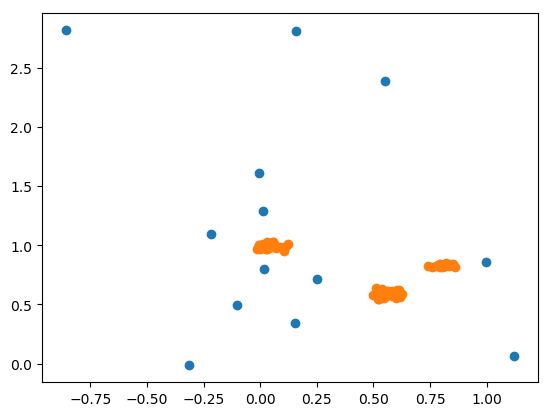

In [4]:
figure()
X = dataset.data
y = dataset.labels
scatter(X[1, y.==1], X[2, y.==1])
scatter(X[1, y.==0], X[2, y.==0])
show()

In [5]:
# set problem dimensions
indim = size(X,1)
hiddendim = 4
latentdim = 2
nlayers = 3

# model constructor parameters
esize = [indim; hiddendim; hiddendim; latentdim]; # encoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim]; # decoder architecture
threshold = 0 # classification threshold, is recomputed when calling fit!
contamination = size(y[y.==1],1)/size(y[y.==0],1) # to set the decision threshold
iterations = 1000
cbit = 200 # when callback is printed
verbfit = true 
activation = Flux.relu
rdelta = 0.01 # reconstruction error threshold when training is stopped

# select only normal data
x = X[:,y .== 0]

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [6]:
# model might have to be restarted if loss is > 0.01
model = AEmodel(esize, dsize, threshold, contamination,
    iterations, cbit, verbfit, activation = activation, rdelta = rdelta)

AnomalyDetection.fit!(model, X)
AnomalyDetection.evalloss(model, X)

loss: 0.0312027

Training ended prematurely after 290 iterations,
reconstruction error 0.009966434069087524 < 0.01
loss: 0.00996643



In [7]:
model(x)

Tracked 2×90 Array{Float64,2}:
 0.778407  0.777546  0.781221  0.789278  …  0.0334943  0.0528599  0.0649934
 0.781987  0.7918    0.784777  0.800843     1.02745    1.05067    1.02162  

In [8]:
x

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [9]:
model(X)

Tracked 2×103 Array{Float64,2}:
 0.778407  0.777546  0.781221  0.789278  …  -0.0210213  0.278762  -0.0194122
 0.781987  0.7918    0.784777  0.800843      1.51136    0.780933   1.06649  

In [10]:
X

2×103 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  -0.00703644  0.252366  -0.216809
 0.821998  0.834235  0.826129  0.848182      1.6113      0.714171   1.09756 

In [11]:
# predict labels
yhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [12]:
model.verbfit = false
tryhat, tsthat = AnomalyDetection.quickvalidate!(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 88
  fp = 2
  fn = 1
precision: 0.8571428571428571
recall: 0.9230769230769231
f1score: 0.8888888888888888
equal error rate: 0.04957264957264958

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 88
  fp = 2
  fn = 1
precision: 0.8571428571428571
recall: 0.9230769230769231
f1score: 0.8888888888888888
equal error rate: 0.04957264957264958


In [13]:
using ScikitLearn.Utils: meshgrid

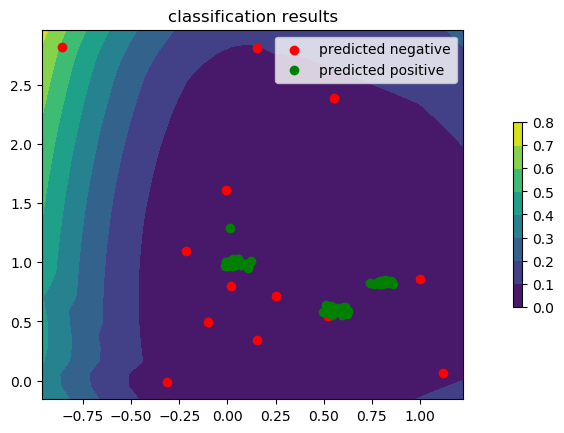

In [16]:
# plot heatmap of the fit
figure()
title("classification results")
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r")
ax = gca()
ylim = ax[:get_ylim]()
xlim = ax[:get_xlim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = AnomalyDetection.loss(model, [xx[i,j], yy[i,j]]).data[1]
    end
end
axsurf = ax[:contourf](xx, yy, zz)
cb = colorbar(axsurf, fraction = 0.05, shrink = 0.5, pad = 0.1)
scatter(X[1, tryhat.==1], X[2, tryhat.==1], c = "r", label = "predicted positive")
scatter(X[1, tryhat.==0], X[2, tryhat.==0], c = "g", label = "predicted negative")
legend(loc = "upper right")
show()

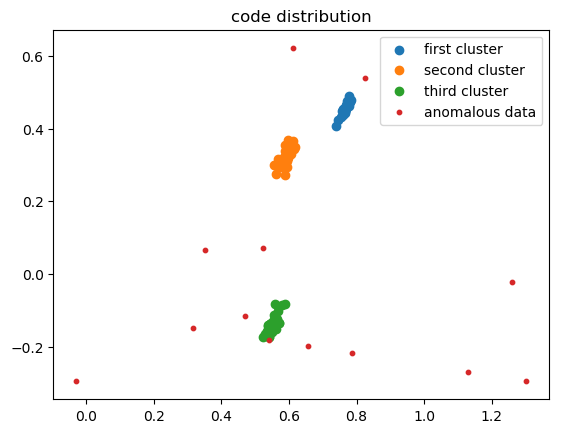

PyObject <matplotlib.legend.Legend object at 0x7f631c29de80>

In [15]:
# what are the codes?
figure()
title("code distribution")
z1 = model.ae.encoder(X[:,1:30]).data
z2 = model.ae.encoder(X[:,31:60]).data
z3 = model.ae.encoder(X[:,61:90]).data
za = model.ae.encoder(X[:,91:end]).data

scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 10, label = "anomalous data")
legend()